# Importing required packages

In [11]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, json

# Loading inference data

*Loading and checking test data*

In [12]:
renamed_inference_data = pd.read_csv('testdf_filtered.csv', sep=';')
renamed_inference_data = renamed_inference_data.drop(columns=renamed_inference_data.columns[0])
renamed_inference_data

,rpm,Accelerator Pedal Position Sensor Voltage,throttle_percent,inj_pulse_width_avg_ms,total_knock_ret_deg,Long Term Fuel Trim Bank 1 (SAE) %,Short Term Fuel Trim Bank 2 (SAE) %,Engine Torque Losses,Short Term Fuel Trim Bank 1 (SAE) %,timing_advance_deg,...,total_ve_bank_1_percent,base_ve_bank_1_percent,fuel_mass_cyl1_gramm,Manifold Vacuum kPa,Accelerator Position E (SAE) %,Calculated Engine Load (SAE) %,Exhaust Cam Des Angle,pratio,Long Term Fuel Trim Bank 2 (SAE) %,aircharge_milligram
0,1705.246649,0.566960,19.583070,2.235,0.0,9.37500,23.110042,47.40,20.341745,26.066176,...,64.746094,59.179688,0.020078,40.4,2.388992,47.186275,83.0,0.575195,8.59375,276.0
1,1705.621984,0.571848,19.656863,2.314,0.0,9.37500,23.676019,47.16,20.692680,26.084893,...,65.039062,59.375000,0.020328,39.8,2.703038,47.389173,83.0,0.582031,8.59375,280.0
2,1706.024129,0.571848,19.735927,2.388,0.0,9.37500,24.282422,47.08,21.068683,26.104947,...,64.746094,59.179688,0.020469,39.4,3.039516,47.606564,83.0,0.587891,8.59375,281.8
3,1706.399464,0.576735,19.809720,2.454,0.0,9.37500,24.848399,46.92,21.419619,26.123663,...,65.332031,59.667969,0.020906,38.8,3.353562,47.809463,83.0,0.593750,8.59375,287.0
4,1706.788204,0.576735,19.886148,2.479,0.0,9.37500,25.434589,46.64,21.783088,26.143048,...,65.234375,59.570312,0.020984,38.4,3.678824,48.019608,83.0,0.597656,8.59375,288.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116990,706.000000,0.000000,12.549020,487.000,0.0,16.40625,-3.125000,28.24,0.000000,6.000000,...,68.847656,58.886719,0.009062,73.6,4.313725,22.745098,124.8,0.246094,17.18750,115.8
116991,706.000000,0.000000,12.549020,485.000,0.0,16.40625,-3.125000,28.32,0.000000,6.000000,...,68.750000,58.789062,9.000000,73.6,4.313725,22.745098,124.8,0.245117,17.18750,115.2
116992,706.000000,0.000000,12.549020,484.000,0.0,16.40625,-3.125000,28.32,0.000000,6.000000,...,68.750000,58.789062,9.000000,73.6,4.313725,22.745098,124.8,0.245117,17.18750,115.0
116993,706.000000,0.000000,12.549020,484.000,0.0,16.40625,-3.125000,28.24,0.000000,6.000000,...,68.457031,58.593750,0.008875,73.8,4.313725,22.745098,124.8,0.244141,17.18750,114.6


* Correleation heatmap of the df

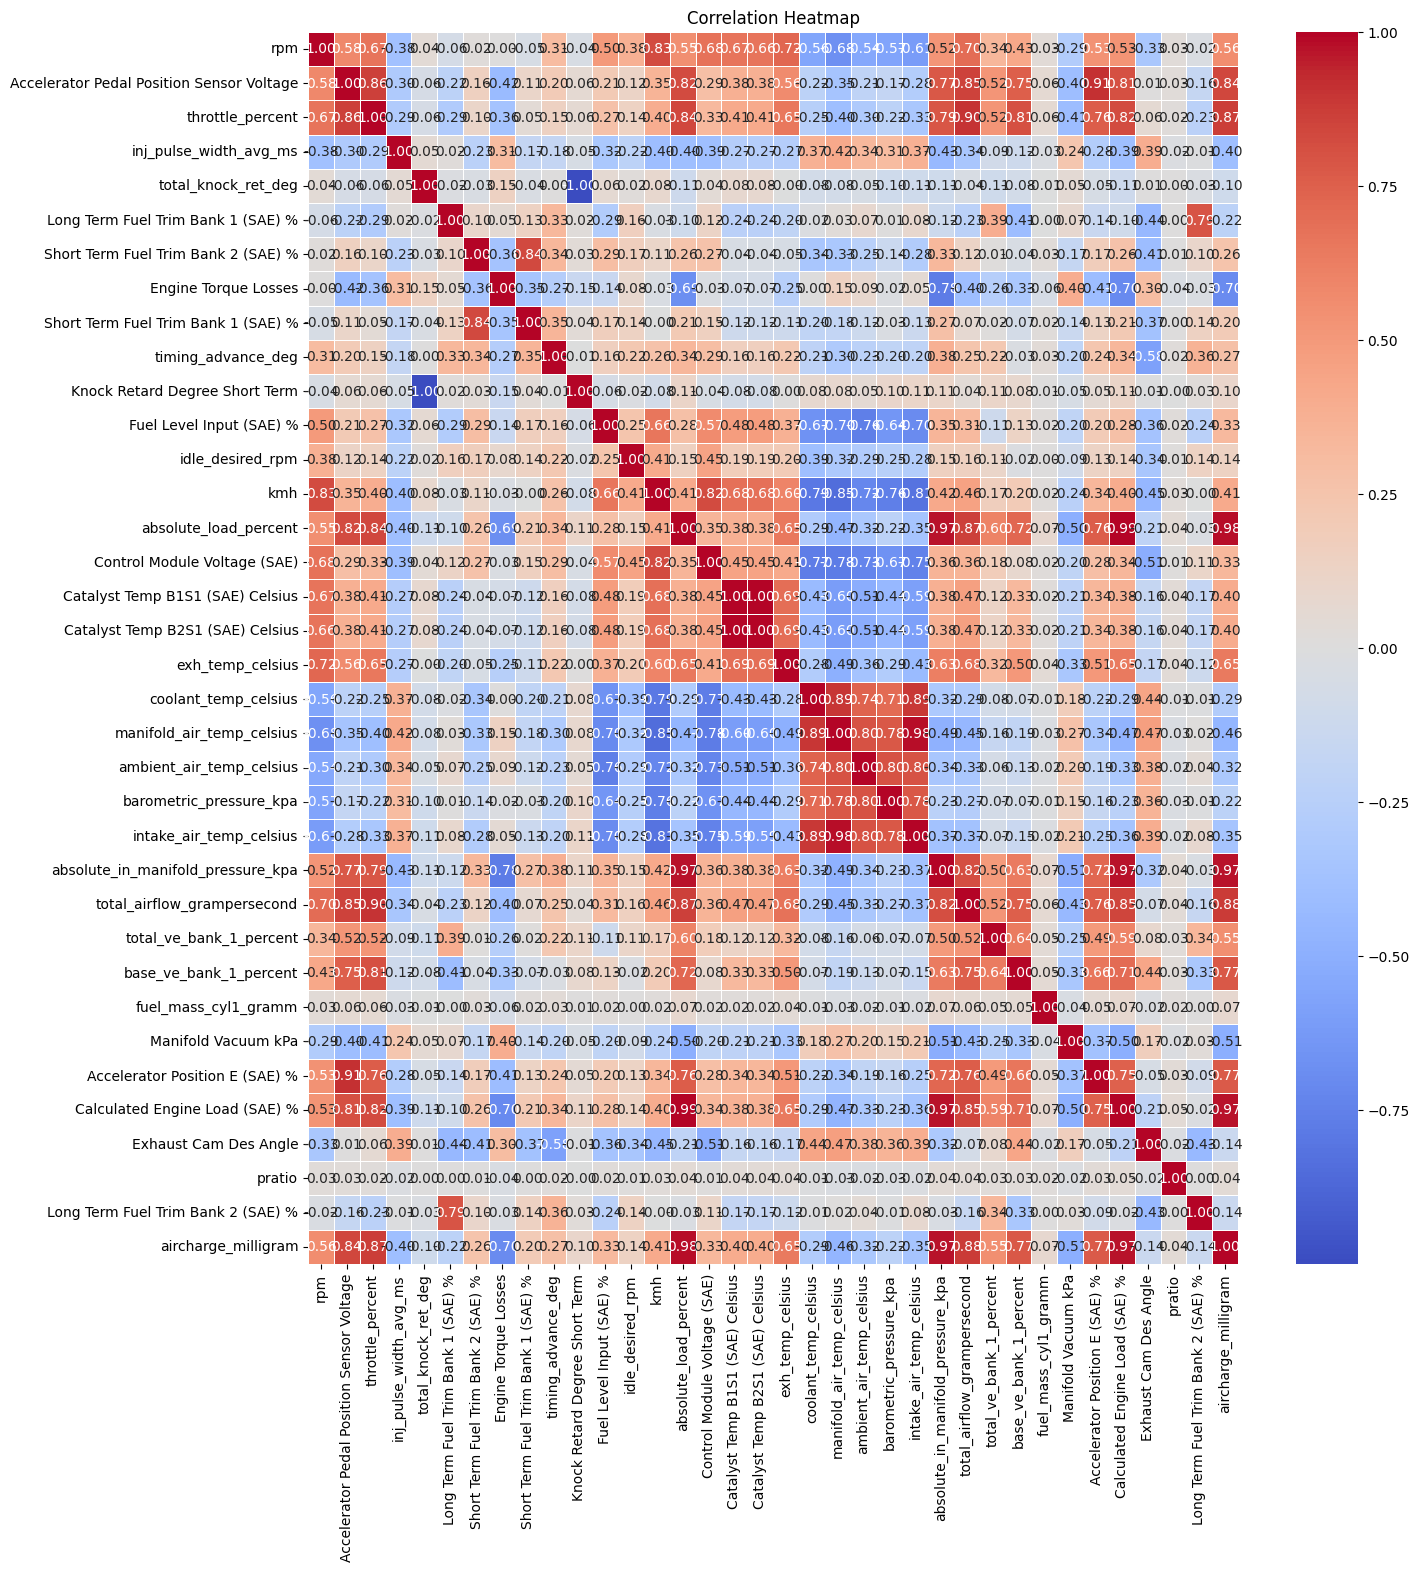

In [13]:
matrix = renamed_inference_data.corr()
plt.figure(figsize=(15,16))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

* Only keeping columns for inference

In [14]:
correlation_dataset = renamed_inference_data[['rpm', 'exh_temp_celsius', 'total_airflow_grampersecond', 'aircharge_milligram']]

# saving for future potential editing or troubleshooting
correlation_dataset.to_csv('correlation_dataset.csv', sep=';')

* Correlation matrix of inference data

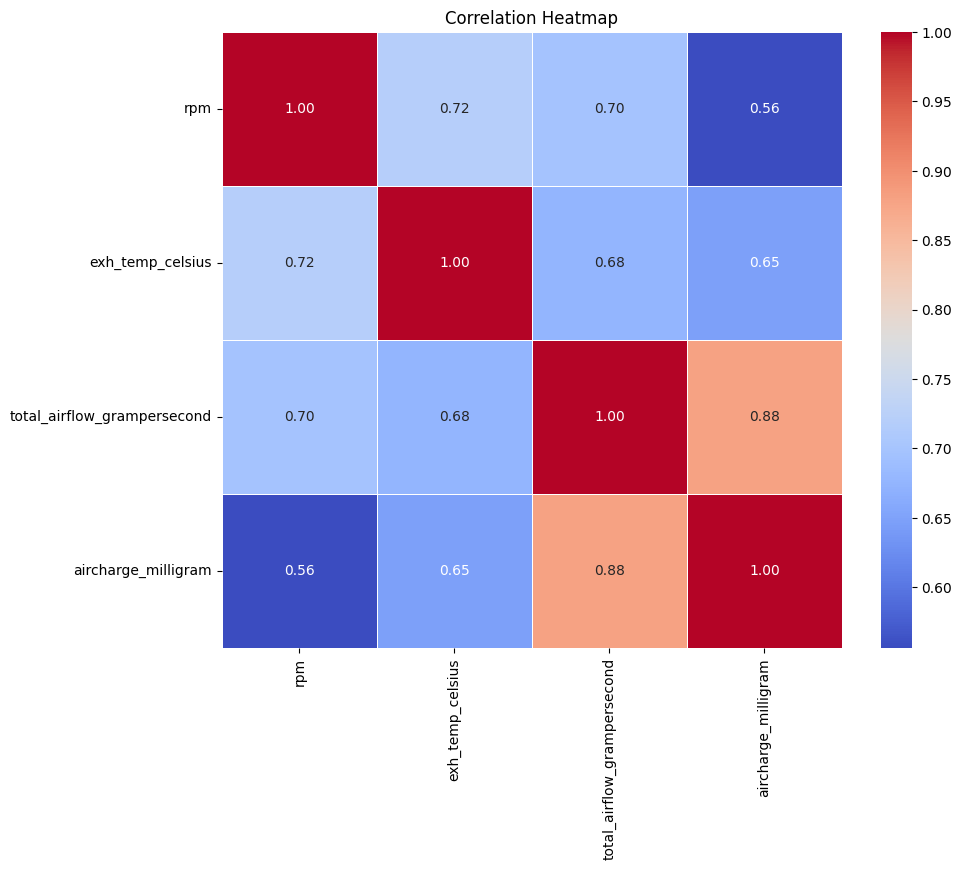

In [15]:
matrix = correlation_dataset.corr()

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Loading model data

* Loading scripted module

In [16]:
ts_model = torch.jit.load("vemodel_scripted.pt", map_location="cpu")
ts_model.eval()
# loading scaler and features used during training for data preprocessing
scaler = joblib.load("x_scaler.pkl")
FEATURES = json.load(open("features.json"))

In [ ]:
# Preprocess inputs exactly like training
X_np_raw = correlation_dataset.to_numpy().astype(np.float32)
X_np = scaler.transform(X_np_raw).astype(np.float32)
x_t = torch.from_numpy(X_np)

# 3) Inference
with torch.no_grad():
    y_pred = ts_model(x_t).squeeze(-1).cpu().numpy()

In [18]:
X_np_raw

array([[1705.2467   ,  659.       ,   34.804688 ,  276.       ],
       [1705.622    ,  659.       ,   34.76953  ,  280.       ],
       [1706.0242   ,  659.       ,   35.26367  ,  281.8      ],
       ...,
       [ 706.       ,  484.       ,    5.397461 ,  115.       ],
       [ 706.       ,  484.       ,    5.1660156,  114.6      ],
       [ 706.       ,  484.       ,    5.1660156,  114.4      ]],
      dtype=float32)

# Visualizing inference

In [19]:
# Axes from unscaled test features
rpm        = X_np_raw[:, 0]
exh_temp   = X_np_raw[:, 1]
airflow_gs = X_np_raw[:, 2]
aircharge  = X_np_raw[:, 3]

Z = np.asarray(y_pred, dtype=np.float32)   # VE (%)

# Clip for nicer colorbar
Z = np.clip(Z, 0, 140)

/var/folders/zg/003k70h94cndfcy2n8s4m7hr0000gn/T/ipykernel_75342/861497312.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grid = df.groupby([pd.cut(df.aircharge, load_edges),


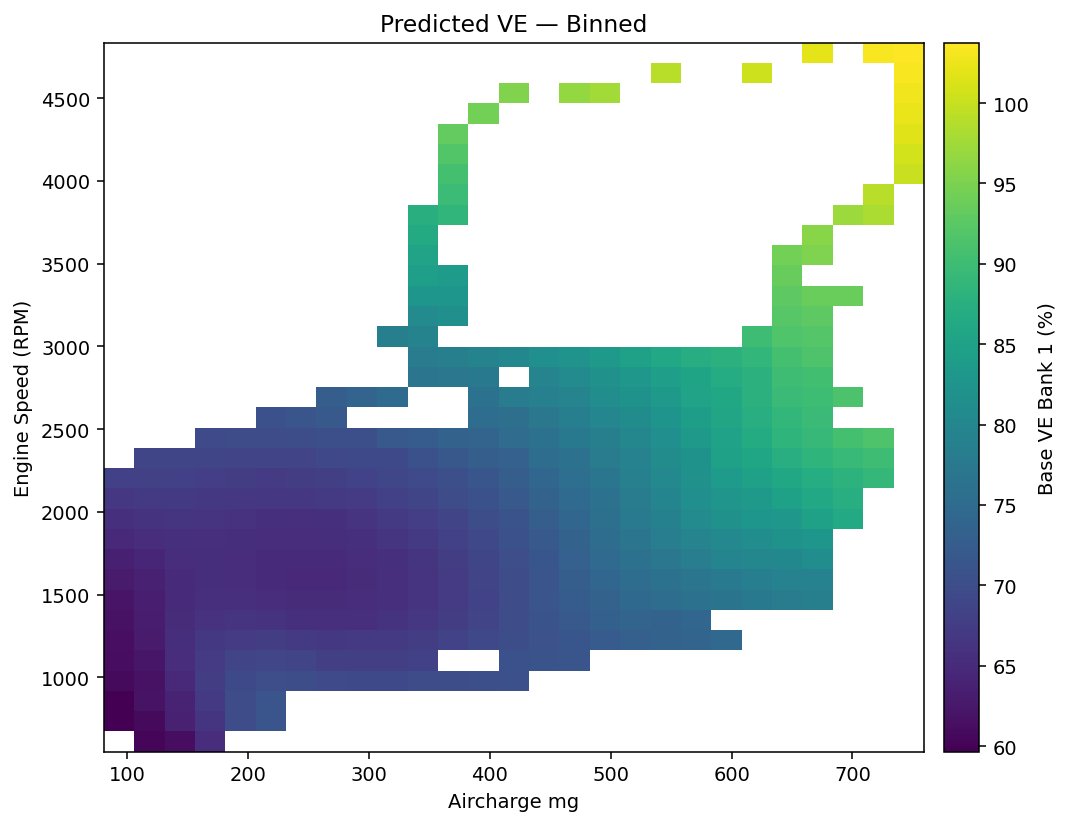

In [20]:
df = pd.DataFrame({
    "rpm": rpm,
    "aircharge": aircharge,
    "ve": Z
})

rpm_edges  = np.linspace(df.rpm.min(), df.rpm.max(), 36)
load_edges = np.linspace(df.aircharge.min(), df.aircharge.max(), 28)

grid = df.groupby([pd.cut(df.aircharge, load_edges),
                   pd.cut(df.rpm, rpm_edges)])["ve"].mean().unstack()

plt.figure(figsize=(8,6), dpi=140)
#                   X edges      Y edges      Z must be (len(Y)-1, len(X)-1)
pc = plt.pcolormesh(load_edges, rpm_edges, grid.values.T, shading="auto")
plt.colorbar(pc, pad=0.02).set_label("Base VE Bank 1 (%)")
plt.xlabel("Aircharge mg")          # <-- X axis
plt.ylabel("Engine Speed (RPM)")    # <-- Y axis
plt.title("Predicted VE — Binned")
plt.tight_layout()
plt.show()